In [5]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from tqdm import tqdm
from torch_geometric.data import Data

##Adding src path to get our code
import sys
sys.path.append('../src')

from utils.graph_utils import interpolate_element_into_nodes, bin_to_torchGraph
from models.GCNN_node import GCNN_node
from datasets.Ice_graph_dataset import Ice_graph_dataset

## Test notebook to try ideas and explain them 

Some of the implemented functions are loaded and demostrated in the following lines. 
Later The code is presented for testing. 

Note the main code is in /src

In [6]:
file_graphs = [dict(np.load(f'../data/{file}')) for file in sorted(os.listdir('../data')) if file[-3:]=='npz']

### Raw Code implementation --- TO BE CLEANED

In [7]:
#Element interpolation with node indexing
element_graphs = []

for file in tqdm(file_graphs,"Interpolating node info into elements"):
    #fetch all node features
    node_features = [feat for feat in file.keys() if file[feat].shape == file['i'].shape and feat != 'i']
    #create a element graph
    element_graph = {
        key:item for key,item in file.items() if key not in node_features
    }
    #Average quantities
    for feature in node_features:
        element_graph[feature] = (file[feature][file['t']].sum(axis=-1)/3)

    #keep track of x,y
    element_graph['node_x'] = file['x']
    element_graph['node_y'] = file['y']


    element_graphs.append(element_graph)

Interpolating node info into elements: 100%|██████████| 25/25 [00:00<00:00, 46.76it/s]


In [8]:
def get_trajectories(
    element_graphs:list[dict],
    element_index:int,
    iter=None
    ):
    """
    Given a list of element graphs, return the trajectories of the nodes that compose the element
    
    Arguments:
        element_graphs : list
            List of element graphs
        element_index : int
            index to of element to track
        iter: int
            iterations to track, if None, compute all trajectory
    returns:
        trajectories : torch.tensor"""
    
    #Get target element's nodes
    nodes = element_graphs[0]['t'][element_index]
    #Get nodes indeces
    node_idx = element_graphs[0]['i'][nodes]

    x,y = [],[]
    for i,hour in enumerate(element_graphs):
        if iter is None or i<iter:
            #having 3 separate index is necesary to keep track of each in x,y
            idx_1 = np.where(hour['i']==node_idx[0])[0]
            idx_2 = np.where(hour['i']==node_idx[1])[0]
            idx_3 = np.where(hour['i']==node_idx[2])[0]
            if len(idx_1)>0 and len(idx_2)>0 and len(idx_3)>0:
                    x.append(hour['node_x'][[idx_1,idx_2,idx_3]])
                    y.append(hour['node_y'][[idx_1,idx_2,idx_3]])

        
    x = np.stack(x)
    y = np.stack(y)

    trajectories = torch.stack([torch.tensor(x),torch.tensor(y)],dim=0).squeeze()
    return trajectories

(6,)


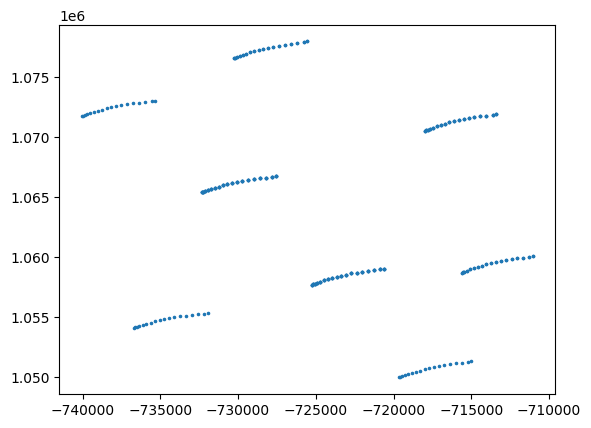

In [10]:
#plot trajectories over neightbouring elements (defined by distance... it is easier)

x_center = element_graphs[0]['x'][9000]
y_center = element_graphs[0]['y'][9000]

neighbours = np.where(np.sqrt((element_graphs[0]['x']-x_center)**2 + (element_graphs[0]['y']-y_center)**2)<12000)
print(neighbours[0].shape)
trajectroies = []
for i in neighbours[0]:
    trajectroies.append(get_trajectories(element_graphs,element_index=i,iter=18))

trajectories = [t for t in trajectroies if t.shape[1]==18]
t = torch.concat(trajectories,dim=-1)

plt.scatter(t[0,:,:],t[1,:,:],s=10,marker='.')

In [11]:

#Data samples generation -- TODO: Document, clean, refactor....
#Ideas ->  create a specific class for this for element graphs management

training_graph_list = []
feature_list = ['Damage', 'Concentration', 'M_wind_x', 'M_wind_y', 'x', 'y']
i = 12 #index of element graph to fetch samples
radius = 12000 #meters
hour_graph = element_graphs[i]
n_generations = 2000
generations = np.random.randint(5000,len(hour_graph['t']),n_generations)

for element in tqdm(generations,"Generating dataset"):

    #get the center of the element and find all neighbours within a radius of r
    x_center = hour_graph['x'][element]
    y_center = hour_graph['y'][element]
    neighbours = np.where(np.sqrt((hour_graph['x']-x_center)**2 + (hour_graph['y']-y_center)**2)<radius)[0]


    #get the next pos of target node
    target_coords = get_trajectories(element_graphs[i:],element,1).flatten().to(torch.float32)

    #concat all node features sequentially (following index(t)) in a tensor
    features = []
    idx_list = []
    for key,item in hour_graph.items():
        if key in feature_list:
            idx_list.append(key)
            features.append(torch.tensor(np.array([item[neighbours]])))

    node_features = torch.cat(features).t().to(torch.float32)


    #get t index of neighbours
    neighbours_t = hour_graph['t'][neighbours]
    #compute all adjacents edges #slow 
    edge_list = []
    for i,element in enumerate(neighbours_t):
        adjacents = []
        for node in element:
            adjacents += list(np.where(np.isin(neighbours_t,node))[0]) #adjacents per node
        adjacents_edges = [[i,j] for j in np.unique(adjacents) if j!=i] #pairs of all adj edges by element index
        edge_list += adjacents_edges
    edges = torch.tensor(edge_list).t()


    #Now we need to consult x,y coordinates of each node of the edges and compute the edge distance
    # and we stack it as a 2xE (2 for each edge end, E as number of edges)
    coord_idx= [i for i,key in enumerate(idx_list) if key in ['x','y']]
    if len(coord_idx)==2:
        edges_coordinates = [
            torch.stack(
                [
                    node_features[edge_row][:,coord_idx[0]],
                    node_features[edge_row][:,coord_idx[1]]
                ]
            )
            for edge_row in edges
        ]
        #we also need to stack the node coordinates for the pos attribute
        positions = torch.stack(
            [
                node_features[:,coord_idx[0]],
                node_features[:,coord_idx[1]]
            ]
        )
    else:
        raise ValueError("Unable to find coordinates for nodes in graph mesh. \nDid you include it in the feature list?")
    
    #now we can compute the norm of each edge vector using torch api
    # unsqueeze to match [num_edges, num_edge_features] shape
    edge_attr = torch.norm(edges_coordinates[1] - edges_coordinates[0],dim=0).unsqueeze(dim=-1).to(torch.float32)

    #Now we can create our torch-geometric graph using the "Data" class
    ice_graph = Data(x=node_features, edge_index=edges, edge_attr=edge_attr,pos=positions, y=target_coords)
    
    training_graph_list.append(ice_graph)

Generating dataset: 100%|██████████| 2000/2000 [00:03<00:00, 532.39it/s]


In [13]:
# Dataset creation, model definition and training

ice_dataset = Ice_graph_dataset(training_graph_list)
example_graph = next(iter(ice_dataset))
num_features = example_graph.x.shape[-1]  # Node feature dimension
hidden_channels = 12
num_classes = 6  #x and y, 3 nodes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNN_node(num_features, hidden_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
mse = nn.MSELoss()

# Set the model to training mode
model.train()

# Define the number of epochs
num_epochs = 50

# Iterate over the dataset for the specified number of epochs
for epoch in range(num_epochs):
    # Initialize the total loss for the epoch
    total_loss = 0
    
    # Iterate over the training graph list
    for graph in ice_dataset:
        # Move the graph to the device
        graph = graph.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform a forward pass
        output = model(graph.x, graph.edge_index, graph.edge_attr)
        #print(output.shape) 
        # Compute the loss
        loss = mse(output, graph.y.flatten())

        #print(loss)        
        # Perform backpropagation
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Add the loss to the total loss for the epoch
        total_loss += loss.item()
    
    # Compute the average loss for the epoch
    avg_loss = total_loss / len(training_graph_list)
    
    # Print the average loss for the epoch
    if epoch%10==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")


Epoch 1/50, Average Loss: 0.0187


KeyboardInterrupt: 

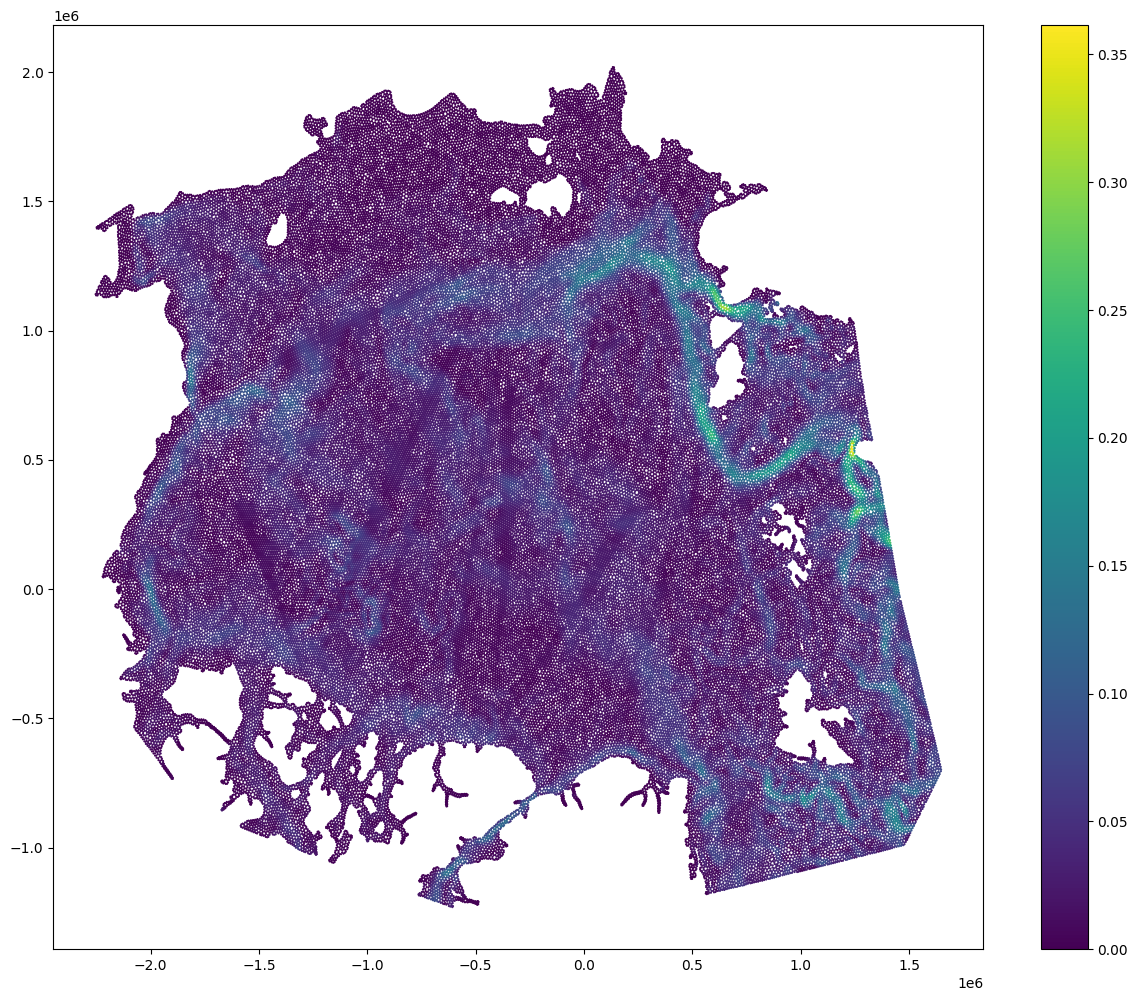

In [15]:
#plt element-interpolated data ?  --> looks cool!
element_graph = element_graphs[12]
plt.figure(figsize=(15,12))
vel_norm = np.sqrt(element_graph['M_ocean_y']**2 + element_graph['M_ocean_x']**2)
plt.scatter(element_graph['x'],element_graph['y'],c=vel_norm, s= 3 ,marker='.',linewidths=.7)
plt.colorbar()